References

[1] PGD: https://github.com/rajatguptakgp/practical_machine_learning/blob/main/projected_gradient_descent.ipynb


[2]


Final Selected Indices (Stable Features - Appeared in ≥ 8 bootstraps): [5, 2, 19, 12, 8, 9, 18, 11, 16, 7, 3, 6, 10, 14, 13, 0, 17, 15, 4, 1]

Final Best Estimated y:
[ -5.06191545  -5.24440199  13.56296372 ...   2.65027916  -4.09692075
 -10.98837551]

Final Best Estimated Beta:
[-5.76896588 -3.76251187 -2.30470989  1.70413364 -1.60481564 -1.53523383
 -1.49636435  1.16990129  1.1039156   1.05189764  0.9888796  -0.90193585
 -0.85304143  0.81505464 -0.72968442  0.47654222  0.38074475  0.2856281
 -0.28556982  0.05356317]

Final Best Error: 203.3242


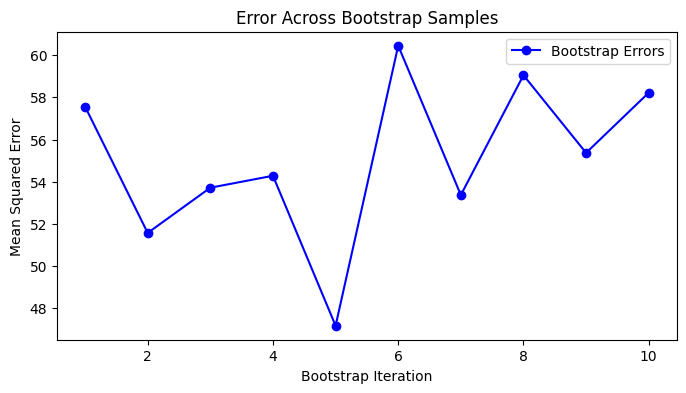

In [29]:
import numpy as np
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster
from collections import Counter

def generate_correlated_matrix(n, m, correlation_strength=0.5, random_seed=None):
    """Generates an n × m matrix where the columns are partially correlated."""
    if random_seed is not None:
        np.random.seed(random_seed)

    base_corr = np.full((m, m), correlation_strength)
    np.fill_diagonal(base_corr, 1.0)

    eigvals = np.linalg.eigvals(base_corr)
    if np.any(eigvals < 0):
        base_corr += np.eye(m) * (abs(min(eigvals)) + 1e-5)

    L = np.linalg.cholesky(base_corr)
    X_independent = np.random.randn(n, m)
    X_correlated = X_independent @ L.T
    return X_correlated

def generate_dependent_variable(X, noise_std=1, random_seed=None):
    """Generates a dependent variable y as a linear combination of X with added Gaussian noise."""
    if random_seed is not None:
        np.random.seed(random_seed)

    n, m = X.shape
    beta = np.random.randn(m, 1)  # Random coefficients
    y_clean = X @ beta  # Compute y
    noise = np.random.normal(0, noise_std, size=(n, 1))  # Add Gaussian noise
    y_noisy = y_clean + noise
    return y_noisy, beta

def hierarchical_clustering(X, max_clusters=20):
    """Performs hierarchical clustering and returns the cluster centroids."""
    corr_matrix = np.corrcoef(X, rowvar=False)
    dissimilarity_matrix = 1 - corr_matrix
    dist_vector = squareform(dissimilarity_matrix, checks=False)
    linkage_matrix = sch.linkage(dist_vector, method='ward')
    cluster_labels = fcluster(linkage_matrix, max_clusters, criterion='maxclust')

    unique_clusters = np.unique(cluster_labels)
    num_clusters = len(unique_clusters)
    cluster_centroids = np.zeros((X.shape[0], num_clusters))

    for i, cluster in enumerate(unique_clusters):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        cluster_centroids[:, i] = np.mean(X[:, cluster_indices], axis=1)

    return num_clusters, cluster_centroids

def gradient_descent_least_squares(C, y, alpha=0.01, iterations=1000, max_clusters=20):
    """Finds the best number of coefficients using gradient descent and selects top s features."""
    n, k = C.shape
    beta = np.zeros((k, 1))
    errors = []
    best_y_estimated, best_beta, best_selected_centroids, best_selected_indices, best_error = None, None, None, None, float("inf")

    for _ in range(iterations):
        residuals = (C @ beta) - y
        gradient = (1 / n) * (C.T @ residuals)
        beta -= alpha * gradient

    sorted_indices = np.argsort(np.abs(beta.flatten()))[::-1]

    for s in range(1, max_clusters + 1):
        selected_indices = sorted_indices[:s]
        selected_centroids = C[:, selected_indices]
        beta_s = beta[selected_indices]
        y_estimated_s = selected_centroids @ beta_s
        error_s = np.linalg.norm(y - y_estimated_s)
        errors.append(error_s)

        if error_s < best_error:
            best_error = error_s
            best_y_estimated = y_estimated_s
            best_beta = beta_s
            best_selected_centroids = selected_centroids
            best_selected_indices = selected_indices

    return best_y_estimated, best_beta, best_selected_centroids, best_selected_indices, best_error, errors

# Bootstrap Sampling
n, m = 5000, 50  # Large matrix size
correlation_strength = 0.9
max_clusters = 20
bootstrap_samples = 10
sample_size = 1000

X = generate_correlated_matrix(n, m, correlation_strength, random_seed=42)
y, beta = generate_dependent_variable(X, noise_std=1, random_seed=42)
num_clusters, cluster_centroids = hierarchical_clustering(X, max_clusters=max_clusters)

all_selected_indices = []
all_errors = []

for i in range(bootstrap_samples):
    # Select a random subset of 1000 rows
    sampled_indices = np.random.choice(n, sample_size, replace=True)
    X_sampled = X[sampled_indices, :]
    y_sampled = y[sampled_indices]

    # Perform clustering and gradient descent on the sampled data
    num_clusters_sampled, cluster_centroids_sampled = hierarchical_clustering(X_sampled, max_clusters=max_clusters)

    best_y_estimated, best_beta, best_selected_centroids, best_selected_indices, best_error, errors = gradient_descent_least_squares(
        cluster_centroids_sampled, y_sampled, alpha=0.1, iterations=1000, max_clusters=num_clusters_sampled
    )

    all_selected_indices.extend(best_selected_indices)  # Store all selected indices
    all_errors.append(best_error)  # Store error for each bootstrap iteration

# Count occurrences of each selected index
index_counts = Counter(all_selected_indices)

# Select features that appeared in at least 80% of bootstrap iterations
selection_threshold = int(0.8 * bootstrap_samples)
final_selected_indices = [idx for idx, count in index_counts.items() if count >= selection_threshold]

# Compute the final model using the most stable features
final_selected_centroids = cluster_centroids[:, final_selected_indices]
final_best_beta = best_beta[: len(final_selected_indices)]
final_best_y_estimated = final_selected_centroids @ final_best_beta
final_best_error = np.linalg.norm(y - final_best_y_estimated)

# Print final results
print(f"\nFinal Selected Indices (Stable Features - Appeared in ≥ {selection_threshold} bootstraps): {final_selected_indices}")
print("\nFinal Best Estimated y:")
print(final_best_y_estimated.flatten())

print("\nFinal Best Estimated Beta:")
print(final_best_beta.flatten())

print(f"\nFinal Best Error: {final_best_error:.4f}")

# Plot error across bootstrap samples
plt.figure(figsize=(8, 4))
plt.plot(range(1, bootstrap_samples + 1), all_errors, marker='o', linestyle='-', color='b', label="Bootstrap Errors")
plt.xlabel("Bootstrap Iteration")
plt.ylabel("Mean Squared Error")
plt.title("Error Across Bootstrap Samples")
plt.legend()
plt.show()


**References:**

[1] https://boostedml.com/2020/06/projected-gradient-descent-for-constrained-optimization.html